In [1]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm

fp = ff1.get_session(2023, 'Abu Dhabi', 'FP2')
#fp_laps = fp.load_laps(with_telemetry=True)
fp.load()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\ricca\AppData\Local\Temp\fastf1.
	Size: 181.41 MB
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.0.3]
req            INFO 	Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20

C:\Users\ricca\AppData\Local\Temp\ipykernel_12364\12414789.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_drv1.append(fastest_drv2).append(fastest_drv3)
C:\Users\ricca\AppData\Local\Temp\ipykernel_12364\12414789.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_drv1.append(fastest_drv2).append(fastest_drv3)


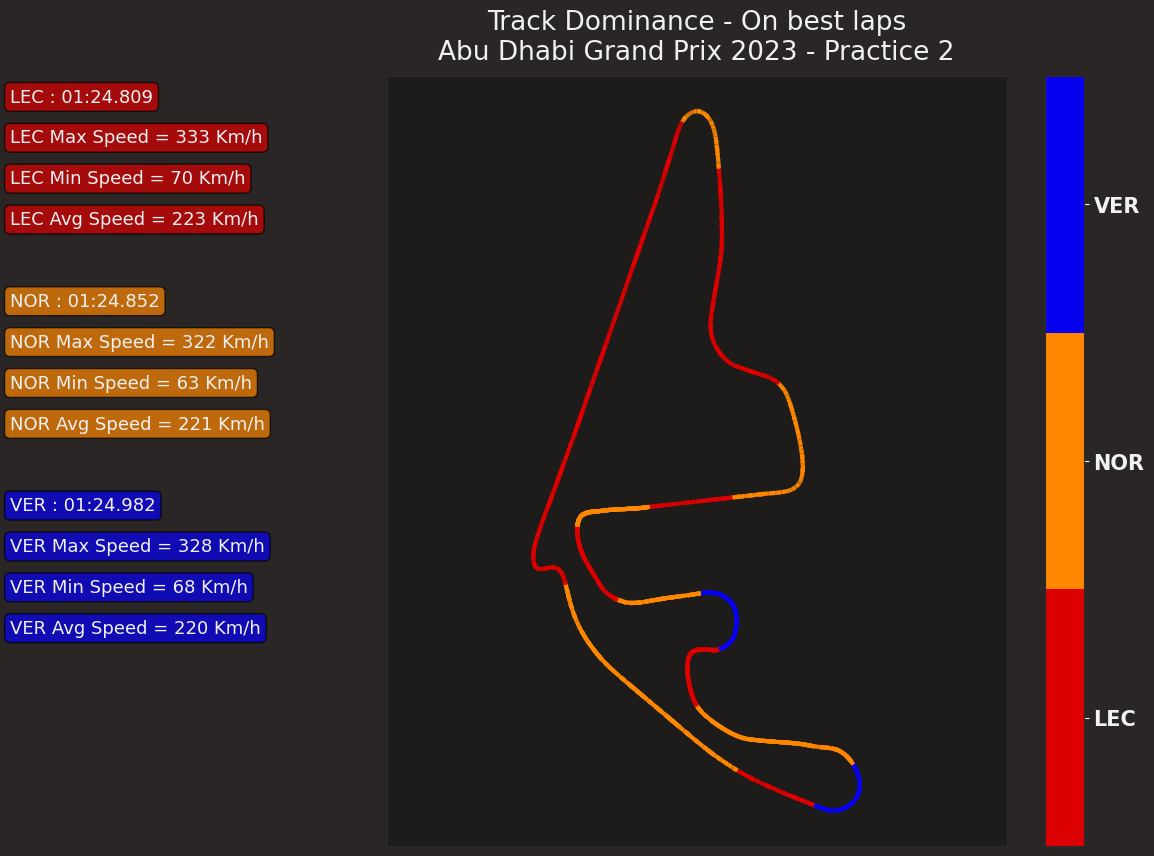

In [16]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plotting.setup_mpl()
fp_laps = fp.laps
driver1='LEC'
driver2='NOR'
driver3='VER'

color_drv1 = ff1.plotting.team_color('FER')
color_drv2 = ff1.plotting.team_color('MCL')
color_drv3= ff1.plotting.team_color('RBR')

laps_drv1 = fp_laps.pick_driver(driver1)
laps_drv2 = fp_laps.pick_driver(driver2)
laps_drv3 = fp_laps.pick_driver(driver3)

fastest_drv1 = laps_drv1.pick_fastest().get_telemetry().add_distance()
fastest_drv2 = laps_drv2.pick_fastest().get_telemetry().add_distance()
fastest_drv3 = laps_drv3.pick_fastest().get_telemetry().add_distance()

fastest_drv1['Driver'] = driver1
fastest_drv2['Driver'] = driver2
fastest_drv3['Driver'] = driver3

driver1MaxSpeed = max(fastest_drv1['Speed'])
driver1AvgSpeed = np.mean(fastest_drv1['Speed'])
driver1MinSpeed = min(fastest_drv1['Speed'])

driver2MaxSpeed = max(fastest_drv2['Speed'])
driver2AvgSpeed = np.mean(fastest_drv2['Speed'])
driver2MinSpeed = min(fastest_drv2['Speed'])

driver3MaxSpeed = max(fastest_drv3['Speed'])
driver3AvgSpeed = np.mean(fastest_drv3['Speed'])
driver3MinSpeed = min(fastest_drv3['Speed'])

telemetry = fastest_drv1.append(fastest_drv2).append(fastest_drv3)

#We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))


telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 2
telemetry.loc[telemetry['Fastest_driver'] == driver3, 'Fastest_driver_int'] = 3


x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

#cmap = cm.get_cmap('cool', 4)
cmap = ListedColormap([color_drv1, color_drv2, color_drv3])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(3)

plt.rcParams['figure.figsize'] = [10, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f"Track Dominance - On best laps\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,5))
cbar.set_ticks(np.arange(1.5, 4.5))
cbar.set_ticklabels([driver1, driver2, driver3], fontsize=15, fontweight = 'bold')

plt.text(-15000, 12000, driver1 +" : "+str(laps_drv1.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv1, alpha=0.7), fontsize=13)
plt.text(-15000, 11000, driver1 +" Max Speed = "+str(driver1MaxSpeed)+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv1, alpha=0.7), fontsize=13)
plt.text(-15000, 10000, driver1 +" Min Speed = "+str(driver1MinSpeed)+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv1, alpha=0.7), fontsize=13)
plt.text(-15000, 9000, driver1 +" Avg Speed = "+str(round(driver1AvgSpeed))+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv1, alpha=0.7), fontsize=13)

plt.text(-15000, 7000, driver2 +" : "+str(laps_drv2.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv2, alpha=0.7), fontsize=13)
plt.text(-15000, 6000, driver2 +" Max Speed = "+str(driver2MaxSpeed)+ " Km/h", bbox=dict(boxstyle='round', facecolor=color_drv2, alpha=0.7), fontsize=13)
plt.text(-15000, 5000, driver2 +" Min Speed = "+str(driver2MinSpeed)+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv2, alpha=0.7), fontsize=13)
plt.text(-15000, 4000, driver2 +" Avg Speed = "+str(round(driver2AvgSpeed))+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv2, alpha=0.7), fontsize=13)

plt.text(-15000, 2000, driver3 +" : "+str(laps_drv3.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv3, alpha=0.7), fontsize=13)
plt.text(-15000, 1000, driver3 +" Max Speed = "+str(driver3MaxSpeed)+ " Km/h", bbox=dict(boxstyle='round', facecolor=color_drv3, alpha=0.7), fontsize=13)
plt.text(-15000, 0000, driver3 +" Min Speed = "+str(driver3MinSpeed)+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv3, alpha=0.7), fontsize=13)
plt.text(-15000, -1000, driver3 +" Avg Speed = "+str(round(driver3AvgSpeed))+" Km/h", bbox=dict(boxstyle='round', facecolor=color_drv3, alpha=0.7), fontsize=13)

plt.show()

In [42]:
drivers = pd.unique(fp.laps['Driver'])
driver_laps_static = fp.laps.pick_drivers(drivers)

In [ ]:
driver_laps = driver_laps_static.loc[((driver_laps_static['Driver'] == "NOR")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==5)) |
                                     ((driver_laps_static['Driver'] == "LEC")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==3))]
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()


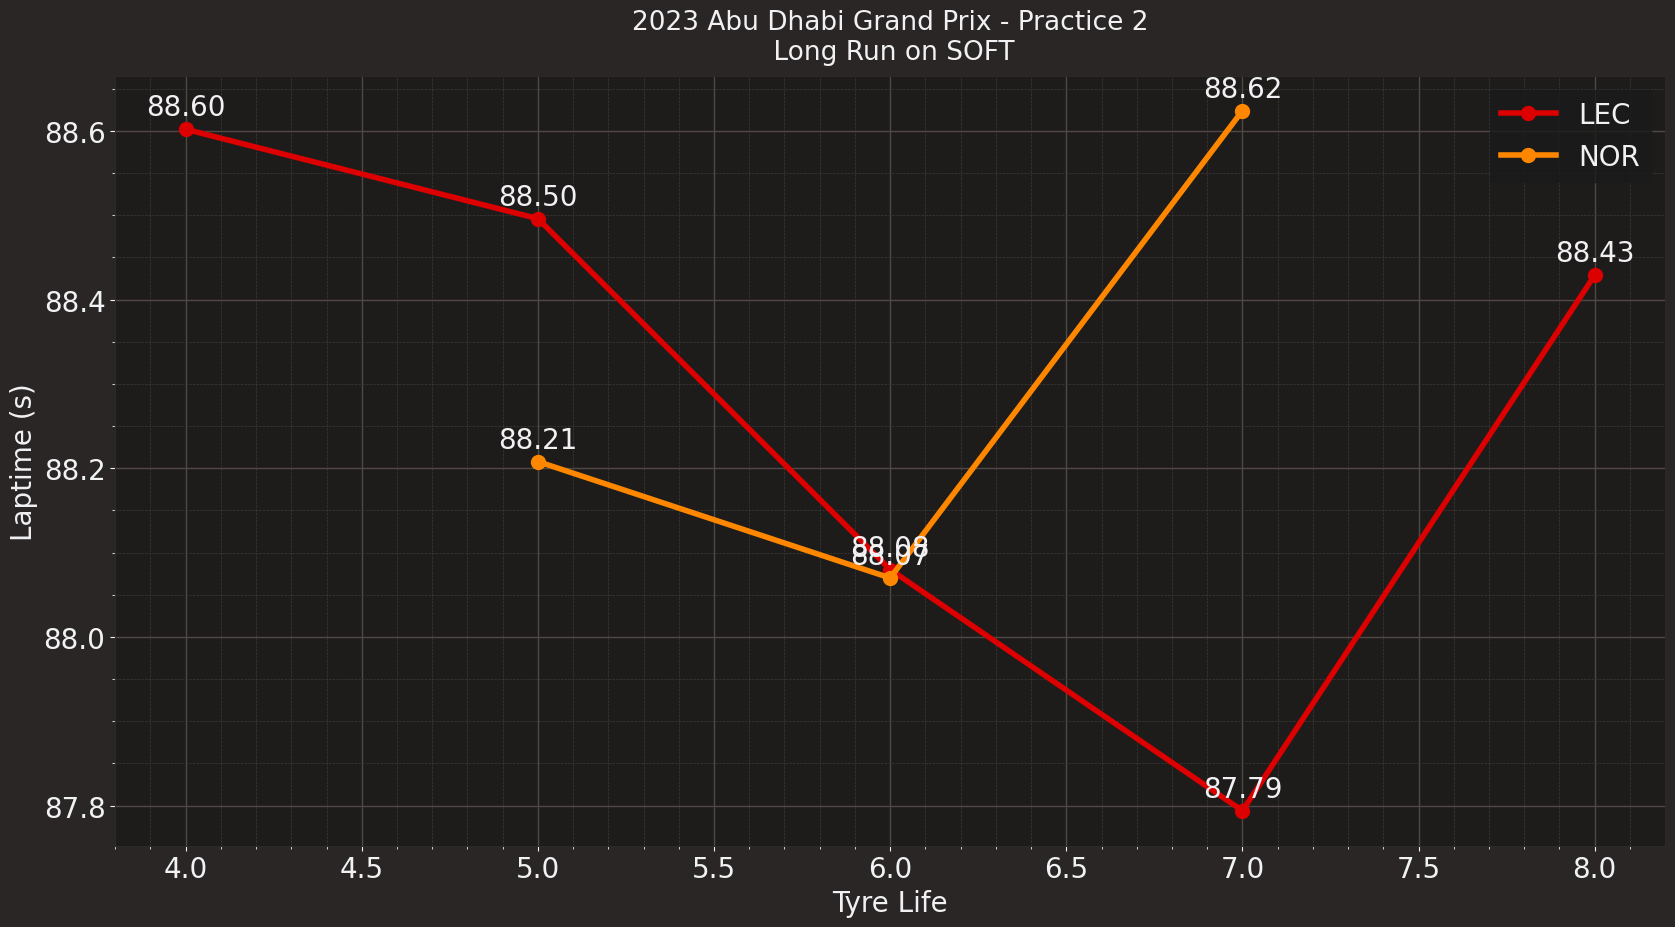

In [44]:

driver_laps = driver_laps.drop(driver_laps[driver_laps['LapTime(s)'] > 90].index)
driver_laps = driver_laps.drop(driver_laps[driver_laps['TyreLife'] < 4].index)
drivers_to_visualize = ["LEC", "NOR"]

# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 10]
plotting.setup_mpl()
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()

# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    single_driver_laps = driver_laps.pick_driver(driver)[['Driver', 'LapNumber', 'LapTime(s)', 'Team', 'TyreLife']]
  
    # Select all the laps from that driver
    single_driver_laps = single_driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(single_driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = single_driver_laps['TyreLife']
    
    # Y-coordinate a smoothed line between all the laptimes
    y = seconds=single_driver_laps['LapTime(s)']
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y, label=driver, color=plotting.team_color(team), linestyle=linestyle, linewidth=4,  marker='o', markersize=10)
    
    for i, txt in enumerate(single_driver_laps['LapTime(s)']):
        ax.annotate(f'{txt:.2f}', (x.iloc[i], y.iloc[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
    

    # Append labels
    ax.set_ylabel("Laptime (s)", size=20)
    ax.set_xlabel("Tyre Life", size=20)
    
    # Set title
    ax.set_title(f"{fp.event.year} {fp.event.EventName} - {fp.name}\n Long Run on SOFT")

    # Generate legend
    ax.legend(prop={'size': 20})
    ax.tick_params(labelsize=20)
    visualized_teams.append(team)

In [ ]:
driver_laps = driver_laps_static.loc[((driver_laps_static['Driver'] == "RUS")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==3)) |
                                     ((driver_laps_static['Driver'] == "PIA")  & (driver_laps_static['IsAccurate']==True) & (driver_laps_static['Stint']==4))]
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()


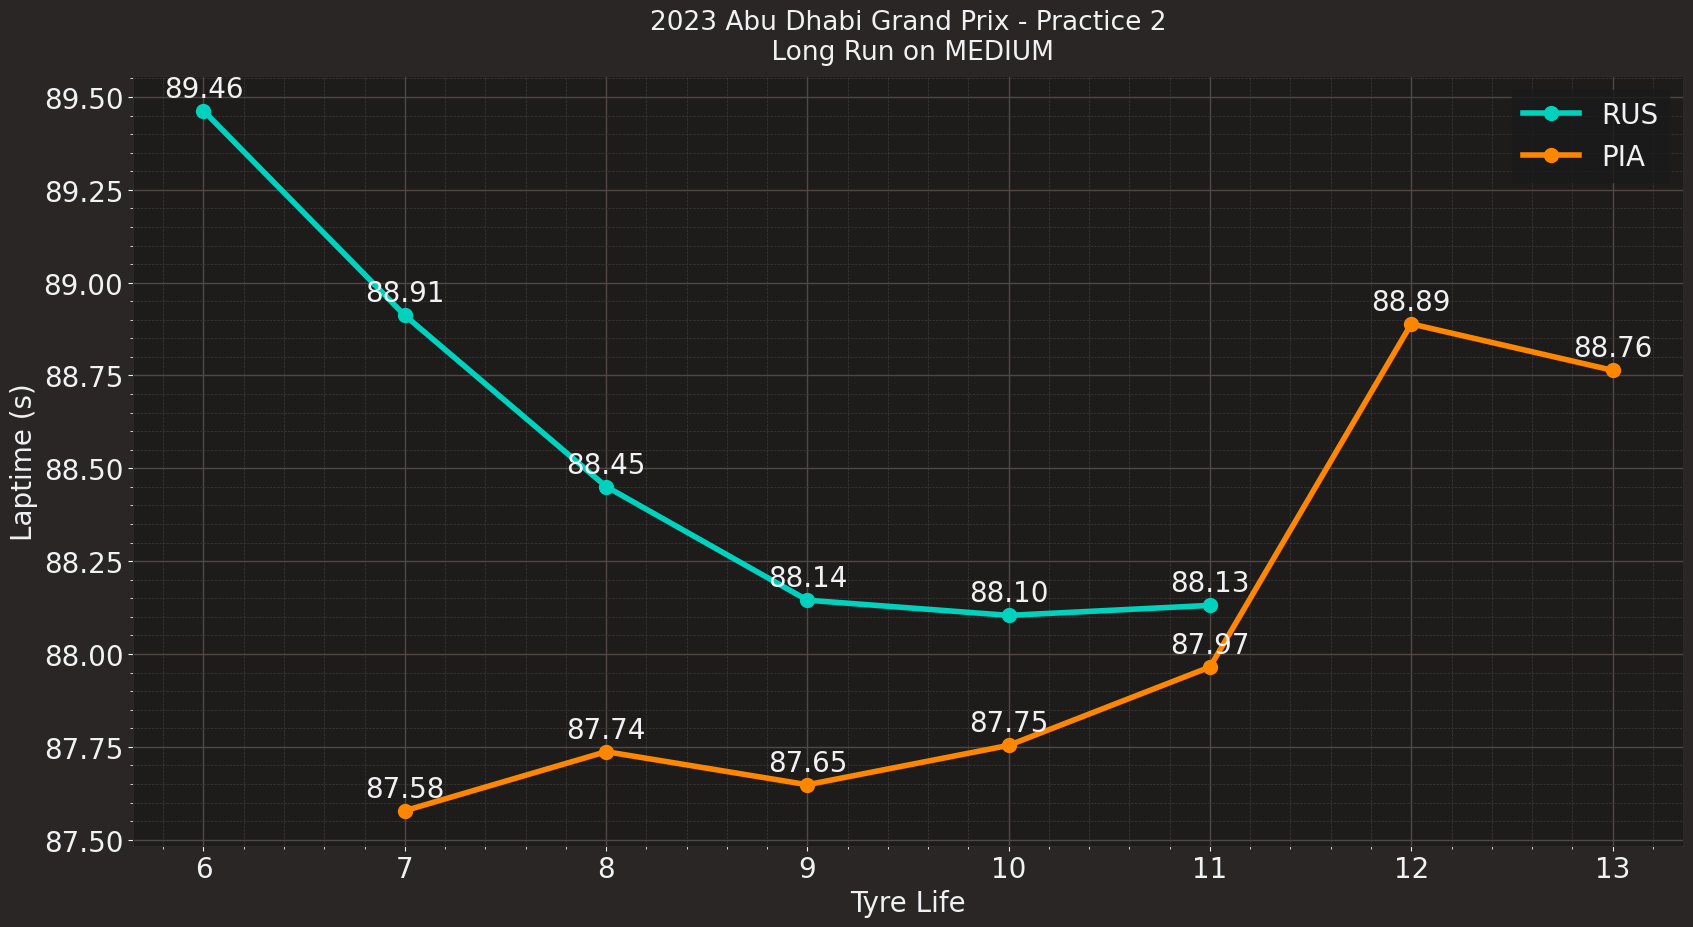

In [46]:

driver_laps = driver_laps.drop(driver_laps[driver_laps['LapTime(s)'] > 90].index)
driver_laps = driver_laps.drop(driver_laps[driver_laps['TyreLife'] < 4].index)
drivers_to_visualize = ["RUS", "PIA"]

# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 10]
plotting.setup_mpl()
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()

# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    single_driver_laps = driver_laps.pick_driver(driver)[['Driver', 'LapNumber', 'LapTime(s)', 'Team', 'TyreLife']]
  
    # Select all the laps from that driver
    single_driver_laps = single_driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(single_driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = single_driver_laps['TyreLife']
    
    # Y-coordinate a smoothed line between all the laptimes
    y = seconds=single_driver_laps['LapTime(s)']
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y, label=driver, color=plotting.team_color(team), linestyle=linestyle, linewidth=4,  marker='o', markersize=10)
    
    for i, txt in enumerate(single_driver_laps['LapTime(s)']):
        ax.annotate(f'{txt:.2f}', (x.iloc[i], y.iloc[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
    

    # Append labels
    ax.set_ylabel("Laptime (s)", size=20)
    ax.set_xlabel("Tyre Life", size=20)
    
    # Set title
    ax.set_title(f"{fp.event.year} {fp.event.EventName} - {fp.name}\n Long Run on MEDIUM")

    # Generate legend
    ax.legend(prop={'size': 20})
    ax.tick_params(labelsize=20)
    visualized_teams.append(team)